# Download dataset

In [1]:
!wget -q http://s3.amazonaws.com/tripdata/201906-citibike-tripdata.csv.zip
!unzip -o 201906-citibike-tripdata.csv.zip

Archive:  201906-citibike-tripdata.csv.zip
  inflating: 201906-citibike-tripdata.csv  


# Load into Pandas dataframe

In [1]:
import pandas as pd
trips = pd.read_csv('201906-citibike-tripdata.csv')
print(f"#cols: {len(trips)}\n")
trips.head()

#cols: 2125370



,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,330,2019-06-01 00:00:01.5000,2019-06-01 00:05:31.7600,3602,31 Ave & 34 St,40.763154,-73.920827,3570,35 Ave & 37 St,40.755733,-73.923661,20348,Subscriber,1992,1
1,830,2019-06-01 00:00:04.2400,2019-06-01 00:13:55.1470,3054,Greene Ave & Throop Ave,40.689493,-73.942061,3781,Greene Av & Myrtle Av,40.698568,-73.918877,34007,Subscriber,1987,2
2,380,2019-06-01 00:00:06.0190,2019-06-01 00:06:26.7790,229,Great Jones St,40.727434,-73.993790,326,E 11 St & 1 Ave,40.729538,-73.984267,20587,Subscriber,1990,2
3,1155,2019-06-01 00:00:06.7760,2019-06-01 00:19:22.5380,3771,McKibbin St & Bogart St,40.706237,-73.933871,3016,Kent Ave & N 7 St,40.720368,-73.961651,33762,Subscriber,1987,1
4,1055,2019-06-01 00:00:07.5200,2019-06-01 00:17:42.5580,441,E 52 St & 2 Ave,40.756014,-73.967416,3159,W 67 St & Broadway,40.774925,-73.982666,31290,Subscriber,1973,1


# Clean dataframe

We're just looking at the temporal graph of trips: remove all missing values and all columns we're not planning to use.

In [2]:
# remove rows with missing values
trips.dropna(inplace=True)

cols = ['start station name', 'end station name', 'usertype', 'birth year', 'gender', 'bikeid']
trips.drop(cols, axis=1, inplace=True)
trips.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude
0,330,2019-06-01 00:00:01.5000,2019-06-01 00:05:31.7600,3602,40.763154,-73.920827,3570,40.755733,-73.923661
1,830,2019-06-01 00:00:04.2400,2019-06-01 00:13:55.1470,3054,40.689493,-73.942061,3781,40.698568,-73.918877
2,380,2019-06-01 00:00:06.0190,2019-06-01 00:06:26.7790,229,40.727434,-73.993790,326,40.729538,-73.984267
3,1155,2019-06-01 00:00:06.7760,2019-06-01 00:19:22.5380,3771,40.706237,-73.933871,3016,40.720368,-73.961651
4,1055,2019-06-01 00:00:07.5200,2019-06-01 00:17:42.5580,441,40.756014,-73.967416,3159,40.774925,-73.982666


# Label encode station ids

Easier to work with them that way, especially if you want to use them as features on a learning task.

In [3]:
def label_encode(combined_series):
    unique_values = combined_series.unique()
    label_mapping = {value: index for index, value in enumerate(unique_values)}
    return combined_series.map(label_mapping), label_mapping

# Combine start and end stations so that they use the same encoding
all_stations = pd.concat([trips['start station id'], trips['end station id']])

# Apply label encoding
encoded_ids, _ = label_encode(all_stations)

# Split the encoded ids back into start and end stations
trips['start station id'] = encoded_ids[:len(trips)].values
trips['end station id'] = encoded_ids[len(trips):].values
trips.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude
0,330,2019-06-01 00:00:01.5000,2019-06-01 00:05:31.7600,0,40.763154,-73.920827,276,40.755733,-73.923661
1,830,2019-06-01 00:00:04.2400,2019-06-01 00:13:55.1470,1,40.689493,-73.942061,126,40.698568,-73.918877
2,380,2019-06-01 00:00:06.0190,2019-06-01 00:06:26.7790,2,40.727434,-73.993790,315,40.729538,-73.984267
3,1155,2019-06-01 00:00:06.7760,2019-06-01 00:19:22.5380,3,40.706237,-73.933871,12,40.720368,-73.961651
4,1055,2019-06-01 00:00:07.5200,2019-06-01 00:17:42.5580,4,40.756014,-73.967416,316,40.774925,-73.982666


# Convert dates to datetime and add secs since epoch

In [4]:
trips['starttime'] = pd.to_datetime(trips['starttime'], format='%Y-%m-%d %H:%M:%S.%f')
trips['stoptime'] = pd.to_datetime(trips['stoptime'], format='%Y-%m-%d %H:%M:%S.%f')

trips['starttime_secs'] = trips['starttime'].apply(lambda x: x.timestamp())
trips['stoptime_secs'] = trips['stoptime'].apply(lambda x: x.timestamp())

# Get a 'duration' column as well, just in case 'tripduration' is incorrect.
trips['duration'] = trips['stoptime'] - trips['starttime']
trips['duration_secs'] = trips['stoptime_secs'] - trips['starttime_secs']

trips[['duration_secs', 'tripduration']].describe()

,duration_secs,tripduration
count,2.125370e+06,2.125370e+06
mean,1.109858e+03,1.109359e+03
std,1.387210e+04,1.387210e+04
min,6.100600e+01,6.100000e+01
25%,3.952172e+02,3.950000e+02
50%,6.839910e+02,6.830000e+02
75%,1.199940e+03,1.199000e+03
max,3.379586e+06,3.379585e+06


# Plot durations ECDF

start date: 2019-06-01 08:00:00
  end date: 2019-06-01 08:05:00
95th %ile: 0 days 00:38:12.040199999
99th %ile: 0 days 01:52:12.610370
max: 0 days 02:36:04.454000
95th %ile: 2292.040200066566
99th %ile: 6732.610370016098
max: 9364.453999996185


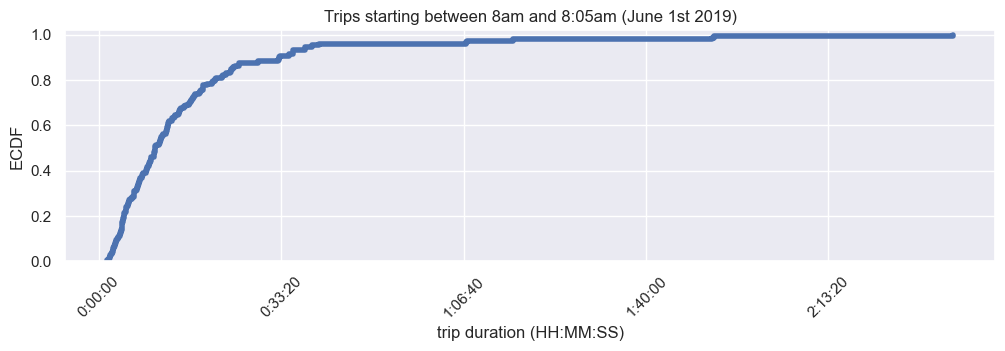

In [5]:
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
sns.set(rc={'figure.figsize':(12,3)})

def format_duration(x, pos):
    return str(timedelta(seconds=int(x)))

def plot_ecdf(start_date, end_date, title):
    print(f"start date: {start_date}")
    print(f"  end date: {end_date}")
    
    filtered = trips[(trips['starttime'] >= start_date) & (trips['starttime'] <= end_date)]
    #print(filtered['duration'].describe())
    
    print(f"95th %ile: {filtered['duration'].quantile(0.95)}")
    print(f"99th %ile: {filtered['duration'].quantile(0.99)}")
    print(f"max: {filtered['duration'].max()}")
    
    print(f"95th %ile: {filtered['duration_secs'].quantile(0.95)}")
    print(f"99th %ile: {filtered['duration_secs'].quantile(0.99)}")
    print(f"max: {filtered['duration_secs'].max()}")
    
    # ECDF
    ax = sns.ecdfplot(data=filtered, x='duration_secs', linewidth=4)
    ax.set_ylim(0, 1.02)
    ax.xaxis.set_major_formatter(FuncFormatter(format_duration))
    ax.set(xlabel='trip duration (HH:MM:SS)', ylabel='ECDF', title=title)
    plt.xticks(rotation=45)
    #plt.savefig('duration_ecdf-2hours.pdf')
    plt.show()

start_date = datetime.strptime('2019-06-01 08:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2019-06-01 08:05:00', '%Y-%m-%d %H:%M:%S')
title = 'Trips starting between 8am and 8:05am (June 1st 2019)'
plot_ecdf(start_date, end_date, title)

start date: 2019-06-01 08:00:00
  end date: 2019-06-01 10:00:00
95th %ile: 0 days 00:35:35.942599999
99th %ile: 0 days 01:07:18.298920
max: 0 days 19:49:47.054000
95th %ile: 2135.9426000118237
99th %ile: 4038.298920106889
max: 71387.05399990082


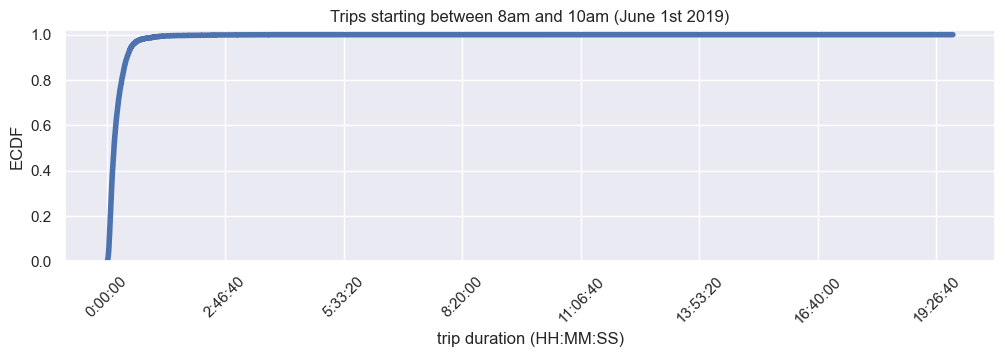

In [6]:
start_date = datetime.strptime('2019-06-01 08:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2019-06-01 10:00:00', '%Y-%m-%d %H:%M:%S')
title = 'Trips starting between 8am and 10am (June 1st 2019)'
plot_ecdf(start_date, end_date, title)

# Plot inter-arrival times distribution

start date: 2019-06-01 08:00:00
  end date: 2019-06-01 08:05:00
95th %ile: 5.981850028038024
99th %ile: 7.310130026340485
max: 17.259000062942505


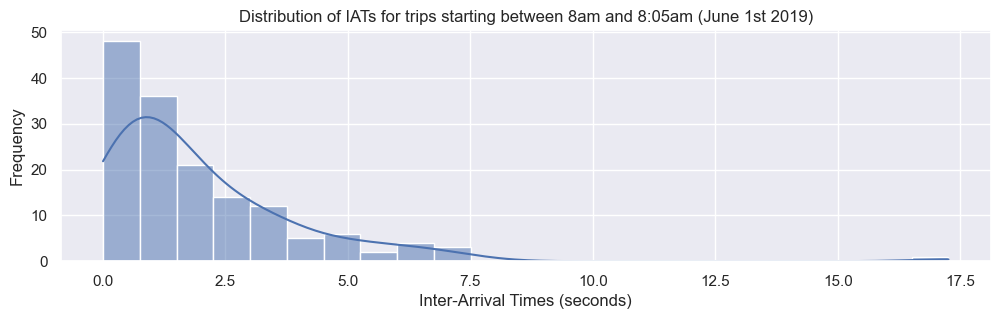

start date: 2019-06-01 08:00:00
  end date: 2019-06-01 08:05:00
95th %ile: 103.61875009536743
99th %ile: 111.45175008773805
max: 113.41000008583069


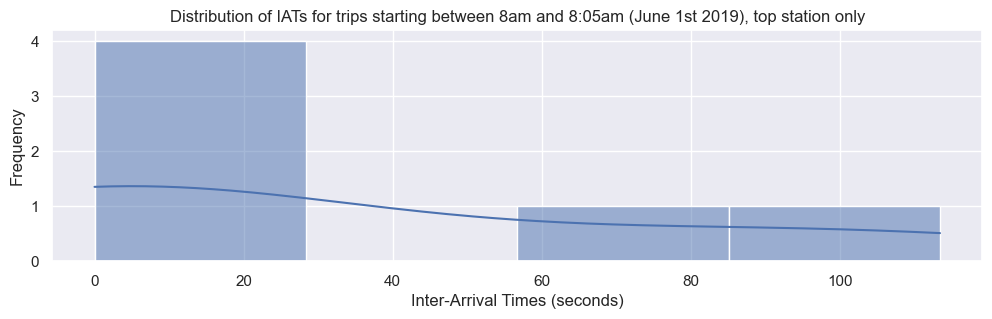

In [7]:
def plot_hist(start_date, end_date, title, by_top_station=False):
    print(f"start date: {start_date}")
    print(f"  end date: {end_date}")
    
    filtered = trips[(trips['starttime'] >= start_date) & (trips['starttime'] <= end_date)]

    if by_top_station:
        top_station = filtered['start station id'].mode()[0]
        filtered = filtered[filtered['start station id'] == top_station]
    
    iat = filtered['starttime_secs'].diff().fillna(0)
    
    print(f"95th %ile: {iat.quantile(0.95)}")
    print(f"99th %ile: {iat.quantile(0.99)}")
    print(f"max: {iat.max()}")
    
    sns.histplot(iat, kde=True)
    plt.xlabel('Inter-Arrival Times (seconds)')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

start_date = datetime.strptime('2019-06-01 08:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2019-06-01 08:05:00', '%Y-%m-%d %H:%M:%S')
plot_hist(start_date, end_date, 'Distribution of IATs for trips starting between 8am and 8:05am (June 1st 2019)')
plot_hist(start_date, end_date, 'Distribution of IATs for trips starting between 8am and 8:05am (June 1st 2019), top station only',
          by_top_station=True)

start date: 2019-06-01 08:00:00
  end date: 2019-06-01 10:00:00
95th %ile: 4.050400018692017
99th %ile: 6.638640146255494
max: 17.259000062942505


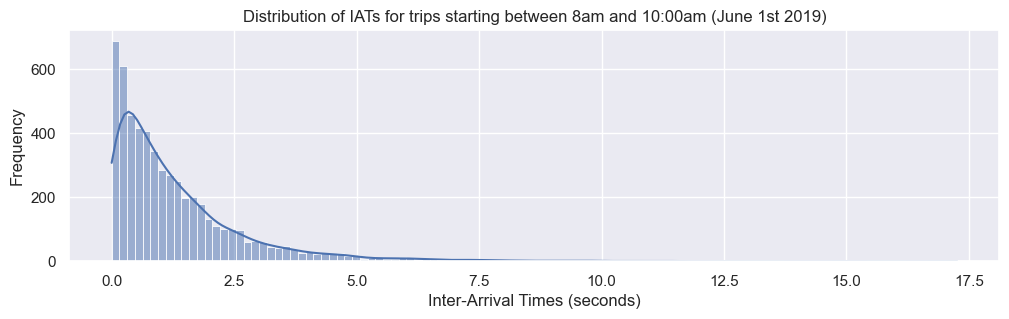

start date: 2019-06-01 08:00:00
  end date: 2019-06-01 10:00:00
95th %ile: 571.5404999971394
99th %ile: 922.1742399358744
max: 1003.3429999351501


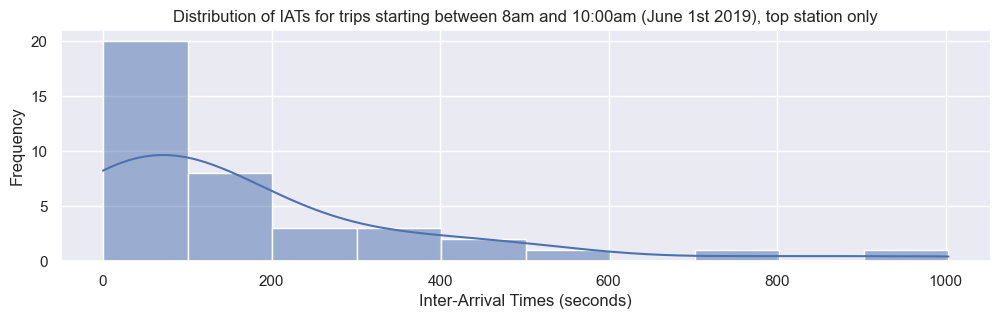

In [8]:
start_date = datetime.strptime('2019-06-01 08:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2019-06-01 10:00:00', '%Y-%m-%d %H:%M:%S')
plot_hist(start_date, end_date, 'Distribution of IATs for trips starting between 8am and 10:00am (June 1st 2019)')
plot_hist(start_date, end_date, 'Distribution of IATs for trips starting between 8am and 10:00am (June 1st 2019), top station only',
          by_top_station=True)

# Visualize temporal graph over NYC map

In [34]:
import folium
from folium import IFrame
import pandas as pd
import numpy as np
from math import cos, sin, atan2, sqrt
import ipywidgets as widgets

# Calculates coords for point located at a certain ratio along the line
def ratio_point(lat1, lon1, lat2, lon2, ratio=0.9):
    lat = lat1 * (1 - ratio) + lat2 * ratio
    lon = lon1 * (1 - ratio) + lon2 * ratio
    return [lat, lon]

# Calculate coords for point located at a fixed offset from the end point
# towards the start point
def offset_point(start_lat, start_lon, end_lat, end_lon, offset=0.001):
    # Calculate the direction vector (from end to start)
    dx = start_lon - end_lon
    dy = start_lat - end_lat
    
    # Length of the vector
    length = sqrt(dx**2 + dy**2)
    
    # Normalize the direction vector
    dx /= length
    dy /= length
    
    # Move along this normalized vector from the end point by the offset amount
    new_lat = end_lat + dy * offset
    new_lon = end_lon + dx * offset
    
    return [new_lat, new_lon]

# Create a map centered around the middle point of the coordinates
map_center_lat = trips[['start station latitude', 'end station latitude']].values.mean()
map_center_lon = trips[['start station longitude', 'end station longitude']].values.mean()

# Create and display map, plotting temporal graph edges that satisfy input temporal predicate
def create_filtered_map(day,
                        starttime_hour_range,
                        starttime_minute_range,
                        stoptime_hour_range,
                        stoptime_minute_range):
    m = folium.Map(location=[map_center_lat, map_center_lon], zoom_start=12, width='85%', height='85%')

    # Filter trips based on the selected time window (starttime)
    starttime_hour_start, starttime_hour_end = starttime_hour_range
    starttime_minute_start, starttime_minute_end = starttime_minute_range
    starttime_start = datetime.strptime(f'2019-06-{day} {starttime_hour_start}:{starttime_minute_start}:00', '%Y-%m-%d %H:%M:%S')
    starttime_end = datetime.strptime(f'2019-06-{day} {starttime_hour_end}:{starttime_minute_end}:00', '%Y-%m-%d %H:%M:%S')
    filtered_df = trips[(trips['starttime'] >= starttime_start) & (trips['starttime'] <= starttime_end)]
    
    # Filter trips based on the selected time window (stoptime)
    stoptime_hour_start, stoptime_hour_end = stoptime_hour_range
    stoptime_minute_start, stoptime_minute_end = stoptime_minute_range
    stoptime_start = datetime.strptime(f'2019-06-{day} {stoptime_hour_start}:{stoptime_minute_start}:00', '%Y-%m-%d %H:%M:%S')
    stoptime_end = datetime.strptime(f'2019-06-{day} {stoptime_hour_end}:{stoptime_minute_end}:00', '%Y-%m-%d %H:%M:%S')
    filtered_df = filtered_df[(filtered_df['stoptime'] >= stoptime_start) & (filtered_df['stoptime'] <= stoptime_end)]

    print(f"starttime=[{starttime_start}, {starttime_end}]")
    print(f"stoptime=[{stoptime_start}, {stoptime_end}]")
    print(f"#matches={len(filtered_df)} out of {len(trips)}")

    for index, row in filtered_df.iterrows():
        folium.CircleMarker(location=[row['start station latitude'], row['start station longitude']],
                            radius=5,
                            color='blue',
                            fill=True,
                            fill_color='blue',
                            fill_opacity=0.6,
                            popup=f'src id: {row["start station id"]}'
                          ).add_to(m)
        
        folium.CircleMarker(location=[row['end station latitude'], row['end station longitude']],
                            radius=5,
                            color='red',
                            fill=True,
                            fill_color='red',
                            fill_opacity=0.6,
                            popup=f'dst id: {row["end station id"]}'
                          ).add_to(m)

        # Draw the trip between the stations.
        f_starttime = row['starttime'].strftime('%Y-%m-%d %H:%M:%S')
        f_stoptime = row['stoptime'].strftime('%Y-%m-%d %H:%M:%S')
        html_content = f'<b>start time:</b> {f_starttime}<br><b>end time:</b> {f_stoptime}'
        iframe = IFrame(html_content, width=250, height=60)

        # Create the Popup with the IFrame
        trip_popup = folium.Popup(iframe)
        folium.PolyLine([(row['start station latitude'], row['start station longitude']),
                        (row['end station latitude'], row['end station longitude'])],
                        color='gray',
                        weight=2.5,
                        opacity=1,
                        popup=trip_popup).add_to(m)
        
#        # Calculate new point for the arrowhead with a fixed offset from the destination
#        arrowhead_location = offset_point(row['start station latitude'], row['start station longitude'],
#                                          row['end station latitude'], row['end station longitude'],
#                                          offset=0.00035)
#        
#        # Determine the angle for the arrowhead
#        angle = atan2(row['end station longitude'] - row['start station longitude'],
#                      row['end station latitude'] - row['end station latitude'])
#        angle = np.degrees(angle) - 90
#        
#        # Add the arrowhead to the map
#        folium.RegularPolygonMarker(location=arrowhead_location,
#                                    number_of_sides=3,
#                                    radius=5,
#                                    rotation=angle,
#                                    color='gray',
#                                    fill_color='gray').add_to(m)
        
    return m

day_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=30,
    step=1,
    description='day:',
    continuous_update=False
)

# startime ranges
starttime_hour_slider = widgets.IntRangeSlider(
    value=[8, 8],
    min=0,
    max=23,
    step=1,
    description='start hour:',
    continuous_update=False
)
starttime_minute_slider = widgets.IntRangeSlider(
    value=[0, 15],
    min=0,
    max=59,
    step=1,
    description='start minute:',
    continuous_update=False
)

# stoptime ranges
stoptime_hour_slider = widgets.IntRangeSlider(
    value=[8, 8],
    min=0,
    max=23,
    step=1,
    description='stop hour:',
    continuous_update=False
)
stoptime_minute_slider = widgets.IntRangeSlider(
    value=[15, 20],
    min=0,
    max=59,
    step=1,
    description='stop minute:',
    continuous_update=False
)

widgets.Box([
    day_slider,
    starttime_hour_slider,
    starttime_minute_slider,
    stoptime_hour_slider,
    stoptime_minute_slider,
])

widgets.interact(
    create_filtered_map,
    day=day_slider,
    starttime_hour_range=starttime_hour_slider,
    starttime_minute_range=starttime_minute_slider,
    stoptime_hour_range=stoptime_hour_slider,
    stoptime_minute_range=stoptime_minute_slider
)

interactive(children=(IntSlider(value=1, continuous_update=False, description='day:', max=30, min=1), IntRange…

<function __main__.create_filtered_map(day, starttime_hour_range, starttime_minute_range, stoptime_hour_range, stoptime_minute_range)>